## Object oriented profile design for use in personal financial forecasting simulation tool

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [145]:
import datetime
from dateutil.relativedelta import relativedelta
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [299]:
class AssetValue():
    """
    Model for approximating asset value and wealth.
    Initially used for property value
    """
    
    def __init__(self, assetReturnRate):
        self.assetReturnRate = assetReturnRate / 12
        
    def getAssetValue(self, assetPrincipal, compoundPeriod):
        # calculates asset value on a periodic compounding per month
        assetValue = assetPrincipal * (1 + self.assetReturnRate)**compoundPeriod
        return assetValue

In [300]:
class Superannuation():
    """
    Note: Assumes superannuation is run via an institution and is not self managed.
    
    """
    
    def __init__(self, contribRate):
        self.superContrib = 0
        self.superInitialBal = 1000   # initial super balance
        self.superReturnRate = 0.06 / 12
        
        self.contribRate = contribRate   # Employer contribution rate
        
        # Cumulative Sum of Super Balance and Value
        self.superBalCumSum = 0
        self.superValCumSum = 0
        
    def superFees(self, phase):
        if phase == 1:
            # phase 1 - before retirement
            self.contribFee = 1/12
        if phase == 2:
            # phase 2 - retirement
            self.contribFee = 0
        self.adminFee = 100
        self.investmentFee = 1/12
        self.insurancePrem = 1/12
        self.indirectCosts = 0.2/12
        self.superFeesTotal = 0
        
        self.superFeesTotal = self.adminFee + self.investmentFee * self.superContrib + \
                            self.contribFee * self.superContrib + self.insurancePrem * self.superContrib + \
                            self.indirectCosts * self.superContrib
        print(f'Super Fees: ${self.superFeesTotal:0.2f}')
        
    def superValue(self, phase):
        
        if self.superBalCumSum == 0:
            print('adding initial value to superVal')
            self.superValCumSum += self.superContrib + self.superInitialBal
        elif phase == 1:
#             print(f'{self.superValCumSum}-{self.superContrib}-{self.superFeesTotal}-{1 + self.superReturnRate}')
            
            self.superValCumSum = (self.superValCumSum + self.superContrib - self.superFeesTotal) * (1 + self.superReturnRate)
        elif phase == 2:
            self.superValCumSum = (self.superValCumSum - self.drawdownAmt - self.superFeesTotal) * (1 + self.superReturnRate)
        
        print(f'Super Value: ${self.superValCumSum:0.2f}')
        
        
    def superBalance(self):
        
        if self.superBalCumSum == 0:
            print('adding initial value to superBal')
            self.superBalCumSum += self.superContrib + self.superInitialBal
        else:
            self.superBalCumSum += self.superContrib - self.superFeesTotal
        
        print(f'Super Balance: ${self.superBalCumSum:0.2f}')
        
    def superContribution(self, phase, income):
        # Monthly income...
        self.superContrib = self.contribRate * income
        print(f'Super Contribution: ${self.superContrib:0.2f}')
        
        self.superFees(phase)
        self.superValue(phase)
        self.superBalance()
        
        
    def superDrawDown(self):
        # Drawdown once retirement starts and contributions cease
        retirementIncome = 25000
        self.drawdownAmt = retirementIncome / 12
        
        self.superContribution(2, 0)   # no income within phase 2
        
        

In [301]:
class Tax():
    """
    Model for taxing income.
    Calculates tax on gross annual income.
    Note: Tax rates are current as of 2019-2020 and sourced from the ATO.
    """
    
    def __init__(self):
        self.tax_table_income = {1: [0, 18200],
                    2: [18201, 37000],
                    3: [37001, 90000],
                    4: [90001, 180000],
                    5: [180001, 1000000000]}   # ridiculous upper limit

        self.tax_table_paymt = {1: [0, 0],
                        2: [0.19, 0],
                        3: [0.325, 3572],
                        4: [0.37, 20797],
                        5: [0.45, 54097]}
    
    def getTaxAmount(self, income):
        
        income = income * 12 # input is per month...
        
        for key, value in self.tax_table_income.items():
            if value[0] <= income <= value[1]:
                tax_to_pay = self.tax_table_paymt[key][1] + self.tax_table_paymt[key][0] * \
                (income - self.tax_table_income[key][0])
                
        monthlyIncomeTax = tax_to_pay / 12
        
        return monthlyIncomeTax

In [302]:
class Savings():
    """
    Model for savings.
    """
    
    def __init__(self, proportionSaved):
        self.proportionSaved = proportionSaved
        
        
        # data capture
        self.dataHistory = []
        self.savingHistory = []
        
    def getSavedAmount(self, remainingIncome):
        """
        Gets amount saved from remainingIncome
        """
        if remainingIncome > 0:
            return remainingIncome*self.proportionSaved
        else: 
            return 0
        
    # Data Capture Functions
    def getSavingHistory(self, date, savingInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.savingHistory.append(savingInfo)

In [303]:
class Expenses():
    """
    Model for general expenses.
    """
    
    def __init__(self, expenses):
        # Everything is on a monthly basis in the model...
        self.expenses = expenses
        
    def increaseExpenseRandomly(self, phase):
        """
        Increase principal by a random amount to simulate expense tranfers.
        This can only occur if the loan is still active. 
        TODO: integrate expenses and ability for profile to override 'active' status to ressurect their paid off loans...
        """

        expensesTemp = 0
        if (0.5 < np.random.uniform(0,1)):
            if phase == 2:
                increaseAmt = np.random.uniform(0.8, 1.2)*(self.expenses / 2)
            else:
                increaseAmt = np.random.uniform(0.8, 1.2)*(self.expenses)
            
            print(f'Expense balance: ${increaseAmt:0.2f}')
            return increaseAmt
        else:
            print('Expenses remain unchanged at:', self.expenses)
            if phase == 2:
                return self.expenses / 2
            else:
                return self.expenses

In [304]:
class Income():
    """
    Model for income (earned, passive, portfolio).
    """
    
    def __init__(self, income):
        # Everything is on a monthly basis in the model...
        self.income = income
        self.remainingIncome = self.income    # init
        self.dateHistory = []
        self.incomeHistory = []

        
    def incomeAfterCosts(self, loanPaymentSum):
        """
        Aggregated Monthly.
        """
        costs = loanPaymentSum
        self.remainingIncome = self.income - costs
        
    def getIncomeHistory(self, date, incomeInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.incomeHistory.append(incomeInfo)

In [305]:
class Loan():
    """
    Model for user profile loans.
    """
    
    def __init__(self, loanID, principal, interestRate, annualPayments, duration, startDate):
        self.principal = principal
        self.interestRate = interestRate
        self.annualPayments = annualPayments
        self.duration = duration
        self.startDate = datetime.datetime.strptime(startDate, '%d-%m-%Y').date()
        self.loanID = loanID
        self.period = 1
        self.endDate = (self.startDate + relativedelta(years=self.duration))
        self.beginBalance = self.principal
        self.endBalance = self.principal
        self.loanPaidOff = False
        self.loanPaidOffDate = 'Not paid off - Active'
        self.loanActive = False
        
        # First loan payment amount
        self.loanPayment = -round(np.pmt(self.interestRate/self.annualPayments, self.duration*self.annualPayments, self.principal), 2)      
    
        # For data capture
        self.dateHistory = []
        self.loanHistory = []
    
    def initDesc(self):
        return f'''Loan {self.loanID} has principal of ${self.principal} over duration {self.duration} years with expected finish date of {self.endDate} - remaining balance: ${self.endBalance}'''
    
    # Main Functions
    def makePayment(self):
        """
        Make a payment against the principal.
        """
        self.loanActive = True
        self.interest = round(((self.interestRate/self.annualPayments) * self.beginBalance), 2)
        self.loanPayment = min(self.loanPayment, self.beginBalance + self.interest)
        self.endBalance = self.beginBalance - (self.loanPayment - self.interest)
        self.period += 1
        self.beginBalance = self.endBalance
        
    def paymentSummary(self):
        try:
            print(f'Period: {self.period} BeginBalance: {self.beginBalance:0.2f} Principal: {self.principal:0.2f} Interest: {self.interest:0.2f} Payment: {self.loanPayment:0.2f}')
        except:
            print('Not enough information. Loan has likely not become active.')

    def loanFinished(self, date):
        """
        Used when a loan is finished.
        """
        #TODO: Add date for when loan finishes... as this may not be constant...
        self.loanPaidOff = True
        self.loanActive = False
        self.loanPaidOffDate = date
    
    # Misc Functions
    def increasePrincipal(self, increaseAmt):
        """
        Increase the amount of loan principal via month begin balance.
        """
        self.beginBalance += increaseAmt
        
    def increasePrincipalRandomly(self):
        """
        Increase principal by a random amount to simulate expense tranfers.
        This can only occur if the loan is still active. 
        TODO: integrate expenses and ability for profile to override 'active' status to ressurect their paid off loans...
        """
        if (0.99 < np.random.uniform(0,1)) and self.loanActive:
            if self.loanPaidOff == False:
                increaseAmt = np.random.randint(0,10)*1000
                self.beginBalance += increaseAmt
                print(f'Increased {self.loanID} balance by ${increaseAmt}')       
        
    # Data Capture Functions
    def getLoanHistory(self, date, loanInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.loanHistory.append(loanInfo)

In [306]:
class Profile(Income, Expenses, Savings, Tax, Superannuation, AssetValue):
    """
    Profile for user. Contains their general information and meta data for financial modeling.
    """
    
    # Initializer / Instance Attributes
    def __init__(self, name, age, retireAge, deadAge, incomePA, expensesPM, proportionSaved):
        self.name = name
        self.age = age
        self.retireAge = retireAge
        self.deadAge = deadAge
        # Loans
        self.hasLoan = False
        self.loanDict = {}
        self.noLoans = 0
        self.loanPaymentSum = 0
        # Income
        self.hasIncome = False
        self.income = incomePA / 12
        self.hasIncome = True
        # Expenses
        self.expenses = expensesPM    # Expenses per month
        # Savings
        self.proportionSaved = proportionSaved

        
        # Inherit Loan init.. by inheriting this class, we can access it's attributes and methods...
        Income.__init__(self, self.income)  # pass attribute to class
        
        # Init Expenses
        Expenses.__init__(self, self.expenses)
        
        
        # Init Savings
        Savings.__init__(self, self.proportionSaved)
        
        # Init Tax
        Tax.__init__(self)
        
        # init super
        Superannuation.__init__(self, 0.095)
        
        # init asset value
        AssetValue.__init__(self, 0.06)
        
        
    # Profile
    def ageStep(self, year):
        """
        Used to age the users profile and step through time.
        """
        self.age += year
    
    def summary(self):
        print(f'{self.name} is {self.age} years old and has income of ${self.income:0.2f} per month.')
    
    # Loan
    def getLoan(self, principal, interestRate, annualPayments, duration, startDate):
        """
        Allocates a loan to the profile.
        """
        self.hasLoan = True
        self.noLoans += 1
        print(f'Number of loans: {self.noLoans}')
        loanID = str(self.noLoans)
        self.loanDict[loanID] = Loan(loanID, principal, interestRate, annualPayments, duration, startDate)
        
    def removeLoan(self, loanID):
        """
        Removes a loan from the profile. TODO: update to remove once paid off.
        """
        try:
            del self.loanDict[loanID]
        except:
            print('Loan doesnt exist')
            
    def loanDesc(self):
        """
        Summary of active loans.
        """
        self.currentLoans = len(self.loanDict)
        try:
            return f'Current active loans for {self.name}: {self.currentLoans}'
        except:
            return f'{self.name} has no loan'
        
    def loanInfo(self):
        """
        Detailed description of loan dict. For debugging purposes.
        """
        for loanID, loanDetails in self.loanDict.items():
            print(f'{loanDetails.initDesc()}')

# Get basic profile information and Initiate Profile

In [307]:
def init_profile():
    myProfile = Profile('Tyler', 26, 65, 80, 52000, 500, 0.25)
    
    myProfile.summary()

    # Loan 1 - mortgage
    myProfile.getLoan(300000, 0.04, 12, 25, '1-1-2021')
    # Loan 2 - car
    myProfile.getLoan(50000, 0.12, 12, 5, '01-01-2025')
    # Loan 3 - car 2
    myProfile.getLoan(7000, 0.08, 12, 10, '01-06-2027')
    myProfile.loanDesc()
    myProfile.loanInfo()
    
    return myProfile

In [308]:
myProfile = init_profile()

Tyler is 26 years old and has income of $4333.33 per month.
Number of loans: 1
Number of loans: 2
Number of loans: 3
Loan 1 has principal of $300000 over duration 25 years with expected finish date of 2046-01-01 - remaining balance: $300000
Loan 2 has principal of $50000 over duration 5 years with expected finish date of 2030-01-01 - remaining balance: $50000
Loan 3 has principal of $7000 over duration 10 years with expected finish date of 2037-06-01 - remaining balance: $7000


## Simulate

### Simulation Iterations

In [286]:
def simulate():
    # Duration of simulation (phase 1)
    dateStart = datetime.date(2020,1,1)
    dateStartTemp = dateStart
    
    
    # Iterate over life with month level grainularity
    print('\n----- ENTERING PHASE ONE -----\n')
    while myProfile.age < myProfile.retireAge:
        # Current datetime of step
        print(f'\n {dateStartTemp}')
        print(f'Monthly Income: ${myProfile.income:0.2f}')

        # Tax
        tax = myProfile.getTaxAmount(myProfile.income)
        print(f'Tax: ${tax:0.2f}')

        # Super
        myProfile.superContribution(1, myProfile.income)

        tempLoanCost = 0

        # Pay debts
        for loanID, loanInfo in myProfile.loanDict.items():
            if myProfile.loanDict[loanID].startDate <= dateStartTemp:

                # Random change of principal injection
                myProfile.loanDict[loanID].increasePrincipalRandomly()

                # If balance remains on loans - make payment
                if 0 < myProfile.loanDict[loanID].beginBalance:
                    # Raise payment against loan
                    myProfile.loanDict[loanID].makePayment()
                    myProfile.loanDict[loanID].paymentSummary()

                    # Capture loan history information for future use
                    myProfile.loanDict[loanID].getLoanHistory(dateStartTemp, myProfile.loanDict[loanID].beginBalance)

                    # Actuate attribute when loan is paid off.
                    if myProfile.loanDict[loanID].beginBalance == 0:
                        print(f'LOAN {loanID} PAID OFF!')
                        # Setting finished to True
                        myProfile.loanDict[loanID].loanFinished(dateStartTemp)

                    else:
                        # Capture loanPayment for totalcost agg
                        print(f'Loan {loanID} - Begin Balance: ${myProfile.loanDict[loanID].beginBalance:0.2f} Payment: {myProfile.loanDict[loanID].loanPayment:0.2f}')
                        tempLoanCost += myProfile.loanDict[loanID].loanPayment

                else:
                    # No principal - either loan hasnt begun or its finished
                    myProfile.loanDict[loanID].getLoanHistory(dateStartTemp, 0)

            else:
                # Too early - no loans are active
                myProfile.loanDict[loanID].getLoanHistory(dateStartTemp, 0)
                pass


        expenses =  myProfile.increaseExpenseRandomly(1)

        myProfile.incomeAfterCosts(tax + tempLoanCost + expenses)
        print(f'Income Remaining: ${myProfile.remainingIncome:0.2f}')
        myProfile.getIncomeHistory(dateStartTemp, myProfile.remainingIncome)

        savedAmt = myProfile.getSavedAmount(myProfile.remainingIncome)
        print(f'Amount saved this month: ${savedAmt:0.2f}')

        
        # asset value
#         myProfile.getAssetValue(myProfile, compoundPeriod)

        yield OrderedDict([('Date', dateStartTemp),
                          ('Income', myProfile.income),
                          ('Tax', myProfile.getTaxAmount(myProfile.income)),
                          ('SuperContrib', myProfile.superContrib),
                           ('SuperBalance', myProfile.superBalCumSum),
                           ('SuperValue', myProfile.superValCumSum),
                          ('LoanDebt', tempLoanCost),
                          ('Expenses', expenses),
                          ('RemainingIncome', myProfile.remainingIncome),
                          ('SavedAmt', savedAmt)])


        # Steps through time month-by-month
        dateStartTemp += relativedelta(months=1)

        # Adds year to age during simulation
        if dateStartTemp.month == 1 and (dateStartTemp.year - dateStart.year) > 0:
            #print(f'Year: {dateStartTemp.year - dateStart.year}')
            myProfile.ageStep(1)
            
    # Iterate over life with month level granularity
    print('\n----- ENTERING PHASE TWO -----\n')
    while myProfile.age < myProfile.deadAge:
        print(f'\n {dateStartTemp}')
        
        # Super drawdown
        myProfile.superDrawDown()
        
        expenses =  myProfile.increaseExpenseRandomly(2)
        
        yield OrderedDict([('Date', dateStartTemp),
                          ('Income', 0),
                          ('Tax', 0),
                          ('SuperContrib', 0),
                           ('SuperBalance', myProfile.superBalCumSum),
                           ('SuperValue', myProfile.superValCumSum),
                          ('LoanDebt', 0),
                          ('Expenses', expenses),
                          ('RemainingIncome', 0),
                          ('SavedAmt', 0)])
        
        
        
        dateStartTemp += relativedelta(months=1)
        # Adds year to age during simulation
        if dateStartTemp.month == 1 and (dateStartTemp.year - dateStart.year) > 0:
            print(f'Year: {dateStartTemp.year - dateStart.year}')
            myProfile.ageStep(1)

In [287]:
df = pd.DataFrame(simulate())


----- ENTERING PHASE ONE -----


 2020-01-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
adding initial value to superVal
Super Value: $1411.67
adding initial value to superBal
Super Balance: $1411.67
Expense balance: $547.49
Income Remaining: $3081.95
Amount saved this month: $770.49

 2020-02-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $1621.62
Super Balance: $1613.56
Expenses remain unchanged at: 500
Income Remaining: $3129.44
Amount saved this month: $782.36

 2020-03-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $1832.63
Super Balance: $1815.44
Expenses remain unchanged at: 500
Income Remaining: $3129.44
Amount saved this month: $782.36

 2020-04-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $2044.69
Super Balance: $2017.33
Expenses remain unchanged at: 500
Income Remaini

Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $58935.29
Super Balance: $36338.44
Period: 163 BeginBalance: 178084.00 Principal: 300000.00 Interest: 596.90 Payment: 1583.51
Loan 1 - Begin Balance: $178084.00 Payment: 1583.51
Period: 86 BeginBalance: 5544.83 Principal: 7000.00 Interest: 37.28 Payment: 84.93
Loan 3 - Begin Balance: $5544.83 Payment: 84.93
Expense balance: $419.51
Income Remaining: $1541.50
Amount saved this month: $385.37

 2034-07-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $59432.86
Super Balance: $36540.33
Period: 164 BeginBalance: 177094.10 Principal: 300000.00 Interest: 593.61 Payment: 1583.51
Loan 1 - Begin Balance: $177094.10 Payment: 1583.51
Period: 87 BeginBalance: 5496.87 Principal: 7000.00 Interest: 36.97 Payment: 84.93
Loan 3 - Begin Balance: $5496.87 Payment: 84.93
Expense balance: $485.96
Income Remaining: $1475.04
Amount saved this month: $368.76

 2034-08-01
Monthly Incom

Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $198815.41
Super Balance: $71870.89
Period: 262 BeginBalance: 2880.73 Principal: 7000.00 Interest: 19.64 Payment: 84.93
Loan 3 - Begin Balance: $2880.73 Payment: 84.93
Expenses remain unchanged at: 500
Income Remaining: $3044.51
Amount saved this month: $761.13

 2049-03-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $200012.39
Super Balance: $72072.78
Period: 263 BeginBalance: 2815.00 Principal: 7000.00 Interest: 19.20 Payment: 84.93
Loan 3 - Begin Balance: $2815.00 Payment: 84.93
Expense balance: $401.63
Income Remaining: $3142.88
Amount saved this month: $785.72

 2049-04-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $201215.35
Super Balance: $72274.67
Period: 264 BeginBalance: 2748.84 Principal: 7000.00 Interest: 18.77 Payment: 84.93
Loan 3 - Begin Balance: $2748.84 Payment: 


 2071-11-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $334433.33
Super Balance: $80193.78
Expense balance: $289.01

 2071-12-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $333911.25
Super Balance: $80093.78
Expense balance: $282.10
Year: 52

 2072-01-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $333386.55
Super Balance: $79993.78
Expenses remain unchanged at: 500

 2072-02-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $332859.24
Super Balance: $79893.78
Expenses remain unchanged at: 500

 2072-03-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $332329.28
Super Balance: $79793.78
Expense balance: $267.06

 2072-04-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $331796.68
Super Balance: $79693.78
Expense balance: $287.00

 2072-05-01
Super Contribution: $0.00
Super Fees: $100.00
Super Value: $331261.41
Super Balance: $79593.78
Expense balance: $291.51

 2072-06-01
Super Contribution: $0.00
Sup

In [288]:
df

,Date,Income,Tax,SuperContrib,SuperBalance,SuperValue,LoanDebt,Expenses,RemainingIncome,SavedAmt
0,2020-01-01,4333.333333,703.889583,411.666667,1411.666667,1411.666667,0.00,547.491165,3081.952585,770.488146
1,2020-02-01,4333.333333,703.889583,411.666667,1613.555556,1621.623333,0.00,500.000000,3129.443750,782.360937
2,2020-03-01,4333.333333,703.889583,411.666667,1815.444444,1832.629783,0.00,500.000000,3129.443750,782.360937
3,2020-04-01,4333.333333,703.889583,411.666667,2017.333333,2044.691266,0.00,500.000000,3129.443750,782.360937
4,2020-05-01,4333.333333,703.889583,411.666667,2219.222222,2257.813055,0.00,500.000000,3129.443750,782.360937
5,2020-06-01,4333.333333,703.889583,411.666667,2421.111111,2472.000454,0.00,500.000000,3129.443750,782.360937
6,2020-07-01,4333.333333,703.889583,411.666667,2623.000000,2687.258789,0.00,500.000000,3129.443750,782.360937
7,2020-08-01,4333.333333,703.889583,411.666667,2824.888889,2903.593417,0.00,500.000000,3129.443750,782.360937
8,2020-09-01,4333.333333,703.889583,411.666667,3026.777778,3121.009717,0.00,542.812399,3086.631351,771.657838
9,2020-10-01,4333.333333,703.889583,411.666667,3228.666667,3339.513099,0.00,483.310698,3146.133052,786.533263


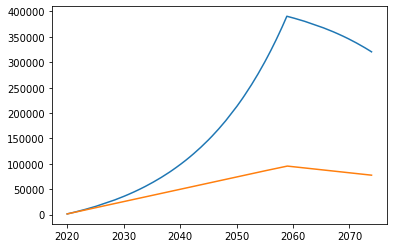

In [289]:
plt.plot(df['Date'], df['SuperValue'])
plt.plot(df['Date'], df['SuperBalance'])

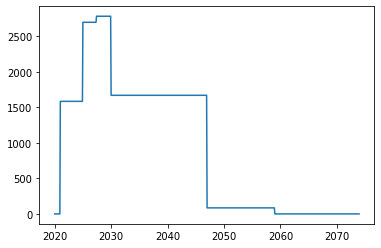

In [290]:
plt.plot(df['Date'], df['LoanDebt'])

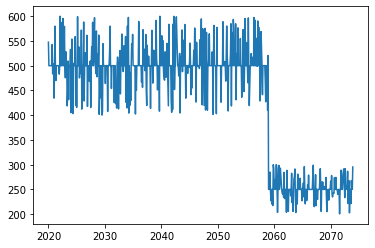

In [291]:
plt.plot(df['Date'], df['Expenses'])

In [ ]:
myProfile.summary()

In [ ]:
myProfile.loanInfo()

In [ ]:
for loanID, _ in myProfile.loanDict.items():
    
    plt.plot(myProfile.loanDict[loanID].dateHistory, myProfile.loanDict[loanID].loanHistory)

In [ ]:
myProfile.loanDict['2'].loanPaidOff

In [ ]:
print('Loan 1')
print('Start Date:', myProfile.loanDict['1'].startDate)
print('Expected End Date:', myProfile.loanDict['1'].endDate)
print('Finish Date:', myProfile.loanDict['1'].loanPaidOffDate)

In [ ]:
print('Loan 2')
print('Start Date:', myProfile.loanDict['2'].startDate)
print('Expected End Date:', myProfile.loanDict['2'].endDate)
print('Finish Date:', myProfile.loanDict['2'].loanPaidOffDate)

In [ ]:
print('Loan 3')
print('Start Date:', myProfile.loanDict['3'].startDate)
print('Expected End Date:', myProfile.loanDict['3'].endDate)
print('Finish Date:', myProfile.loanDict['3'].loanPaidOffDate)

In [ ]:
plt.plot(myProfile.dateHistory, myProfile.incomeHistory)
plt.title('Remaining Income')
plt.xlabel('Year')
plt.ylabel('$ Amount')